# Manual of DATE (Dual-Attentive-Tree-aware-Embedding) model

* Date: 2020. 5. 27.
* Written by Yeon Soo Choi, Technical Officer, Research Unit, WCO
* Revised by Sundong Kim, Institute for Basic Science
* Original paper
    * Title: DATE: Dual Attentive Tree-aware Embedding for Customs Frauds Detection
    * Authors
        - IBS: Sundong Kim*, Karandeep Singh, Meeyoung Cha
        - NCKU: Yu-Che Tsai∗, Cheng-Te Li
        - WCO: Yeon Soo Choi
        - NCS: Etim Ibok
    * Source: https://github.com/Roytsai27/Dual-Attentive-Tree-aware-Embedding
        - All the python codes are included in this one notebook.
* Data: Synthetic import data (xxx at transaction-item level)


## Summary (in non-technical terms)

**DATE (Dual-Attentive-Tree-aware-Embedding)** is a neural network model to detect undervalued imports.  

Imagine that you **("neural networks")** are the head of a Customs targeting centre composed of **100 risk analysts ("decision trees")**. For a given import, you task the analysts with reporting **the probability of undervaluation** and **the estimate of additional revenue from the inspection ("dual-task")**.  

How would you put 100 different reports together in making your final decision?
Simply averaging their predictions may neglect some valuable information hidden in 100 reports. The DATE model help you keep all the information while paying more **ATTENTION** to specific pieces. Firstly, if there are a majority group of reports significantly similar to each other, you may pay more **ATTENTION** to those reports. Secondly, if you have analysts specialized in the specific HS code and importer of the given import, you may pay more **ATTENTION** to their reports. In the end, you make your final decision based on all the reports, however, in proportion to the amount of attention you paid to respective reports.

## Summary (in technical terms)

Now, lets take an overview of the model with some technical terms. For a given import, the DATE model works in the following steps;

* **XGBoost**: The model passes the import into a XGBoost model which constructs multiple(eg. 100) decision trees. 
* **Embedding**: Each tree's decision (decision path, leaf-id) is transformed into a set of numbers to be fed into neural networks. 
* **Multi-head Self-attention**
    - Self-attention: The numeric value (importance, weight) of each leaf-id is adjusted based on its correlation/interaction with other leaf-ids.
    - Multi-head: Self-iteration is repeated in multiple times to achieve its robustness.
* **Attention**: The numeric values (importance, weight) of each leaf-id is re-adjusted based on its correlation/interaction with the given importer-id and item-id(HScode).

## OUTLINE
* [Part 1. Preprocess data](#part1)
* [Part 2. XGBoost model](#part2)
* [Part 3. DATE (XGBoost + Neural Networks + Attention)](#part3)
* [Part 4. Evaluation](#part4)
* [Part 5. Practice of functions](#part5)
* [Part 6. XGBoost + Logistic Regression model](#part6)

# Part 1. Preprocess <a id='part1'></a>

## 1.1. Set environment

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
pd.set_option('display.max_columns',100)
from collections import defaultdict
from itertools import islice, combinations
from datetime import datetime as dt
import warnings
warnings.filterwarnings("ignore")

## 1.2. Load data

In [29]:
df = pd.read_csv('./data/synthetic-imports-declarations.csv', encoding = "ISO-8859-1")

In [30]:
df.head(5)

,sgd.id,sgd.date,importer.id,declarant.id,country,office.id,tariff.code,quantity,gross.weight,fob.value,cif.value,total.taxes,illicit,revenue
0,SGD1,13-01-02,IMP826164,DEC3207,CNTRY680,OFFICE92,8703241128,1581,26494,2390,2809,647,0,0
1,SGD2,13-01-02,IMP837219,DEC1525,CNTRY680,OFFICE51,8703232926,1,3910,204098,266140,3262,0,0
2,SGD3,13-01-02,IMP117406,DEC4146,CNTRY680,OFFICE59,8517180000,1,699231,302275,302275,5612,0,0
3,SGD4,13-01-02,IMP435108,DEC4242,CNTRY376,OFFICE51,8703222900,1288,22958,3019,4160,514,0,0
4,SGD5,13-01-02,IMP717900,DEC6324,CNTRY454,OFFICE92,8545200000,42,21248,156348,239549,397,1,980


In [31]:
# Define columns to use
column_to_use = ['sgd.date','office.id','importer.id', 
                 'declarant.id','tariff.code','country',
                 'cif.value','quantity','gross.weight',
                 'total.taxes','revenue','illicit']

In [32]:
# Select columns
df = df[column_to_use]

In [33]:
df=df.sort_values('sgd.date')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 12 columns):
sgd.date        100000 non-null object
office.id       100000 non-null object
importer.id     100000 non-null object
declarant.id    100000 non-null object
tariff.code     100000 non-null int64
country         100000 non-null object
cif.value       100000 non-null int64
quantity        100000 non-null int64
gross.weight    100000 non-null int64
total.taxes     100000 non-null int64
revenue         100000 non-null int64
illicit         100000 non-null int64
dtypes: int64(7), object(5)
memory usage: 9.9+ MB


In [35]:
print("Finish loading data...")

Finish loading data...


## 1.3. Define functions to be used

### 1.3.1. "merge_attributes" function [(link to practice)](#practice1)

This "merge_attributes" fuction is to create a new categorical variable by combining multiple existing categorical variables into one.

In [36]:
def merge_attributes(df: pd.DataFrame, *args: str) -> None: 
    # Note: "*args" represents multiple arguments, i.e. multiple variable names could come. 
    # Note: "-> None" represents that this function returns None (i.e. type annotation)
    """
    dtype df: dataframe
    dtype *args: strings (attribute names that want to be combined)
    """
    # To set data type of each argument as string
    iterables = [df[arg].astype(str) for arg in args] 
    # To name the newly combined variable/column
    columnName = '&'.join([*args]) 
    # To create a column for the combined variable
    fs = [''.join([v for v in var]) for var in zip(*iterables)] # "*" represents "unzip"
    df.loc[:, columnName] = fs

### 1.3.2. "preprocess" function [(link to practice)](#practice2)

This fuction is to;
* generate additional features such as unitprice, weight-unitprice and effective tariff rate;
* merge some attributes, using the above "merge_attributes" function; and 
* generate date-related features.

In [37]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    # Note: "-> pd.DataFrame" represents that this function returns a dataframe.
    """
    dtype df: dataframe
    rtype df: dataframe
    """
    df = df.dropna(subset=['total.taxes']) # Remove rows which does not have these values.
    df.loc[:, 'Unitprice'] = df['cif.value']/df['quantity']
    df.loc[:, 'WUnitprice'] = df['cif.value']/df['gross.weight']
    df.loc[:, 'TaxRatio'] = df['total.taxes'] / df['cif.value']
    df.loc[:, 'TaxUnitquantity'] = df['total.taxes'] / df['quantity']
    df.loc[:, 'HS6'] = df['tariff.code'].apply(lambda x: int(x // 10000))
    df.loc[:, 'HS4'] = df['HS6'].apply(lambda x: int(x // 100))
    df.loc[:, 'HS2'] = df['HS4'].apply(lambda x: int(x // 100))
    
    # Made a general function "merge_attributes" for supporting any combination    
    merge_attributes(df, 'HS6','country')
    merge_attributes(df, 'office.id','importer.id')
    merge_attributes(df, 'office.id','HS6')
    merge_attributes(df, 'office.id','country')
    
    # another way of combining features
    #df.loc[:, 'HS6.country'] = [str(i)+'&'+j for i, j in zip(df['HS6'], df['country'])]
    
    
    # Day of Year of sgd.date
    tmp2 = {}
    for date in set(df['sgd.date']):
        tmp2[date] = dt.strptime(date, '%y-%m-%d') 
    tmp_day = {}
    tmp_week = {}
    tmp_month = {}
    yearStart = dt(tmp2[date].date().year, 1, 1)
    for item in tmp2:
        tmp_day[item] = (tmp2[item] - yearStart).days
        tmp_week[item] = int(tmp_day[item] / 7)
        tmp_month[item] = int(tmp_day[item] / 30)
        
    df.loc[:, 'SGD.DayofYear'] = df['sgd.date'].apply(lambda x: tmp_day[x])
    df.loc[:, 'SGD.WeekofYear'] = df['sgd.date'].apply(lambda x: tmp_week[x])
    df.loc[:, 'SGD.MonthofYear'] = df['sgd.date'].apply(lambda x: tmp_month[x])
    
    return df

### 1.3.3. "find_risk_profile" function [(link to practice)](#practice3)

This function is to identify/calculate risk-profiling indicators of the features;
* option 1 (topk): Lists of top n high-risk categories in the features
* option 2 (ratio): illicit ratio of categories in the features

In [38]:
def find_risk_profile(df: pd.DataFrame, 
                      feature: str, 
                      topk_ratio: float, 
                      adj: float, 
                      option: str) -> list or dict:
    """
    dtype feature: str
    dtype topk_ratio: float (range: 0-1)
    dtype adj: float (to modify the mean)
    dtype option: str ('topk', 'ratio')
    rtype: list(option='topk') or dict(option='ratio')
    
    The option topk is usually better than the ratio because of overfitting.
    """

    # Top-k suspicious item flagging
    if option == 'topk':
        # Group data by a specified feature(vairable)
        total_cnt = df.groupby([feature])['illicit']
        # Set the number of entities to be included a black list.
        nrisky_profile = int(topk_ratio*len(total_cnt))+1
        # For each entity, calculate 'total number of frauds' divided by 'total number of imports' 
        adj_prob_illicit = total_cnt.sum() / (total_cnt.count()+adj)  # Smoothed mean
        return list(adj_prob_illicit.sort_values(ascending=False).head(nrisky_profile).index)
    
    # Illicit-ratio encoding (Mean target encoding)
    # Refer: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-munging/target-encoding.html
    # Refer: https://towardsdatascience.com/why-you-should-try-mean-encoding-17057262cd0
    elif option == 'ratio':
        # For target encoding, we just use 70% of train data to avoid overfitting (otherwise, test AUC drops significantly)
        total_cnt = df.sample(frac=0.7).groupby([feature])['illicit']
        # prob_illicit = total_cnt.mean()  # Simple mean
        adj_prob_illicit = total_cnt.sum() / (total_cnt.count()+adj)  # Smoothed mean
        return adj_prob_illicit.to_dict()

### 1.3.4. "tag_risky_profiles" function [(link to practice)](#practice4)

This function is to generate risk-profiling tags of the features

In [39]:
def tag_risky_profiles(df: pd.DataFrame, 
                       profile: str, 
                       profiles: list or dict, 
                       option: str) -> pd.DataFrame:
    """
    dtype df: dataframe
    dtype profile: str
    dtype profiles: list(option='topk') or dictionary(option='ratio')
    dtype option: str ('topk', 'ratio')
    rtype: dataframe
    
    The option topk is usually better than the ratio because of overfitting.
    """
    # Top-k suspicious item flagging
    if option == 'topk':
        d = defaultdict(int) # return 0 for not-defined keys
        for id in profiles:
            d[id] = 1
    #     print(list(islice(d.items(), 10)))  # For debugging
        df.loc[:, 'RiskH.'+profile] = df[profile].apply(lambda x: d[x])
    
    # Illicit-ratio encoding
    elif option == 'ratio':
        overall_ratio_train = np.mean(train.illicit) # When scripting, saving it as a class variable is clearer.
        df.loc[:, 'RiskH.'+profile] = df[profile].apply(lambda x: profiles.get(x,overall_ratio_train))
    return df

##  1.4. Preprocess data with pre-defined functions

In [40]:
# Dataset settings
data_length = df.shape[0]
train_ratio = 0.6
valid_ratio = 0.8
train_length = int(data_length*train_ratio)
valid_length = int(data_length*valid_ratio)

In [41]:
# One way of splitting train/valid/test set
df=df.sort_values('sgd.date')
train = df.iloc[:train_length,:]
valid = df.iloc[train_length:valid_length,:]
test = df.iloc[valid_length:,:]

## Another way of splitting - explicitly split by time
#train = df[df["sgd.date"] < "2013-11-01"]
#valid = df[(df["sgd.date"] >= "2013-11-01") & (df["SGD.DATE"] < "2013-11-01")]
#test = df[df["sgd.date"] >= "2013-12-01"]

In [42]:
train.shape, valid.shape, test.shape

((60000, 12), (20000, 12), (20000, 12))

In [43]:
df.columns

Index(['sgd.date', 'office.id', 'importer.id', 'declarant.id', 'tariff.code',
       'country', 'cif.value', 'quantity', 'gross.weight', 'total.taxes',
       'revenue', 'illicit'],
      dtype='object')

In [44]:
# save label data
train_reg_label = train['revenue'].values
valid_reg_label = valid['revenue'].values
test_reg_label = test['revenue'].values
train_cls_label = train["illicit"].values
valid_cls_label = valid["illicit"].values
test_cls_label = test["illicit"].values

In [45]:
# Run preprocessing
train = preprocess(train)
valid = preprocess(valid)
test = preprocess(test)

In [46]:
train.columns

Index(['sgd.date', 'office.id', 'importer.id', 'declarant.id', 'tariff.code',
       'country', 'cif.value', 'quantity', 'gross.weight', 'total.taxes',
       'revenue', 'illicit', 'Unitprice', 'WUnitprice', 'TaxRatio',
       'TaxUnitquantity', 'HS6', 'HS4', 'HS2', 'HS6&country',
       'office.id&importer.id', 'office.id&HS6', 'office.id&country',
       'SGD.DayofYear', 'SGD.WeekofYear', 'SGD.MonthofYear'],
      dtype='object')

In [47]:
# Add a few more risky profiles
risk_profiles = {}
profile_candidates = ['importer.id', 'declarant.id', 'tariff.code', 'quantity', 'HS6', 'HS4', 'HS2', 'office.id'] + [col for col in train.columns if '&' in col]

for profile in profile_candidates:
    option = 'topk'
    risk_profiles[profile] = find_risk_profile(train, profile, 0.1, 10, option=option)
    train = tag_risky_profiles(train, profile, risk_profiles[profile], option=option)
    valid = tag_risky_profiles(valid, profile, risk_profiles[profile], option=option)
    test = tag_risky_profiles(test, profile, risk_profiles[profile], option=option)

In [48]:
train.columns

Index(['sgd.date', 'office.id', 'importer.id', 'declarant.id', 'tariff.code',
       'country', 'cif.value', 'quantity', 'gross.weight', 'total.taxes',
       'revenue', 'illicit', 'Unitprice', 'WUnitprice', 'TaxRatio',
       'TaxUnitquantity', 'HS6', 'HS4', 'HS2', 'HS6&country',
       'office.id&importer.id', 'office.id&HS6', 'office.id&country',
       'SGD.DayofYear', 'SGD.WeekofYear', 'SGD.MonthofYear',
       'RiskH.importer.id', 'RiskH.declarant.id', 'RiskH.tariff.code',
       'RiskH.quantity', 'RiskH.HS6', 'RiskH.HS4', 'RiskH.HS2',
       'RiskH.office.id', 'RiskH.HS6&country', 'RiskH.office.id&importer.id',
       'RiskH.office.id&HS6', 'RiskH.office.id&country'],
      dtype='object')

In [50]:
# Features to use in a classifier
column_to_use = ['cif.value', 'total.taxes', 'gross.weight', 'quantity', 'Unitprice', 'WUnitprice', 'TaxRatio', 'TaxUnitquantity', 'tariff.code', 'HS6', 'HS4', 'HS2', 'SGD.DayofYear', 'SGD.WeekofYear', 'SGD.MonthofYear'] + [col for col in train.columns if 'RiskH' in col] 

# Extract only numeric values from data to be fed into models
X_train = train[column_to_use].values
X_valid = valid[column_to_use].values
X_test = test[column_to_use].values

In [51]:
# impute nan
X_train = np.nan_to_num(X_train, 0)
X_valid = np.nan_to_num(X_valid, 0)
X_test = np.nan_to_num(X_test, 0)

In [52]:
# make sure the data size are correct
print("Checking data size...")
print(X_train.shape, train_cls_label.shape, train_reg_label.shape)
print(X_valid.shape, valid_cls_label.shape, valid_reg_label.shape)
print(X_test.shape, test_cls_label.shape, test_reg_label.shape)

Checking data size...
(60000, 27) (60000,) (60000,)
(20000, 27) (20000,) (20000,)
(20000, 27) (20000,) (20000,)


## 1.5. Save all the preprocessed data

In [53]:
# store all data in a dictionary
all_data = {"raw":{"train":train,"valid":valid,"test":test},
 "xgboost_data":{"train_x":X_train,"train_y":train_cls_label,\
                 "valid_x":X_valid,"valid_y":valid_cls_label,\
                 "test_x":X_test,"test_y":test_cls_label},
 "revenue":{"train":train_reg_label,"valid":valid_reg_label,"test":test_reg_label}}

In [54]:
from collections import Counter
print("Checking label distribution")
cnt = Counter(train_cls_label)
print("Training:",cnt[1]/cnt[0])
cnt = Counter(valid_cls_label)
print("Validation:",cnt[1]/cnt[0])
cnt = Counter(test_cls_label)
print("Testing:",cnt[1]/cnt[0])

Checking label distribution
Training: 0.08246585722275343
Validation: 0.0803219359369092
Testing: 0.08230964879051897


In [55]:
# pickle a variable to a file
# reference for pickle: https://www.datacamp.com/community/tutorials/pickle-python-tutorial
file = open('./processed_data.pickle', 'wb')
pickle.dump(all_data, file)
file.close()

# Part 2. XGBoost model <a id='part2'></a>

## 2.1. Set environment

In [56]:
import numpy as np 
import pandas as pd 
import pickle
import copy
import os 
from xgboost import XGBClassifier
from sklearn.metrics import f1_score,roc_auc_score
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch.autograd import Variable

import warnings
warnings.filterwarnings("ignore")

## 2.2. Load the preprocessed data in Part 1

In [58]:
# load preprocessed data
with open("./processed_data.pickle","rb") as f :
    processed_data = pickle.load(f)
print(processed_data.keys())
print("Finish loading data...")

dict_keys(['raw', 'xgboost_data', 'revenue'])
Finish loading data...


Split data into train-, valid- and test-set.

In [59]:
# train/test data 
train = processed_data["raw"]["train"]
valid = processed_data["raw"]["valid"]
test = processed_data["raw"]["test"]

Split labels into train-, valid- and test-set.

In [60]:
# Revenue data for regression target 
revenue_train = processed_data["revenue"]["train"]
revenue_valid = processed_data["revenue"]["valid"]
revenue_test = processed_data["revenue"]["test"]

Take logged values of revenue, and normalize them. --> getting more densed distribution/minimizing outliers' impacts.  
As we assume no information on valid-data and test-data, they are normalized with the information of train-data. 

In [61]:
# normalize revenue by f(x) = log(x+1)/max(xi)
norm_revenue_train = np.log(revenue_train+1)
norm_revenue_valid = np.log(revenue_valid+1)
norm_revenue_test = np.log(revenue_test+1) 
global_max = max(norm_revenue_train) 
norm_revenue_train = norm_revenue_train/global_max
norm_revenue_valid = norm_revenue_valid/global_max
norm_revenue_test = norm_revenue_test/global_max

Split xgboost data into train-, valid- and test-set.

In [62]:
# Xgboost data 
xgb_trainx = processed_data["xgboost_data"]["train_x"]
xgb_trainy = processed_data["xgboost_data"]["train_y"]
xgb_validx = processed_data["xgboost_data"]["valid_x"]
xgb_validy = processed_data["xgboost_data"]["valid_y"]
xgb_testx = processed_data["xgboost_data"]["test_x"]
xgb_testy = processed_data["xgboost_data"]["test_y"]

## 2.3. Define functions to be used
### 2.3.1. "find_best_threshod" function

In [63]:
def find_best_threshold(model,x_list,y_test,best_thresh = None):
    '''
    This function is to find the best threshold to determine "to inspect" or "not".
    We assume that we inspect only the imports where predicted probability of fraud is above the threshold.
    The input arguments are;
    - dtype model: scikit-learn classifier model
    - dtype x_list: list or array of features (data)
    - dtype y_test: array of true labels 
    '''
    # Predict probability of fraud of each import.
    y_pred_prob = model.predict_proba(x_list)[:,1]
    # Set threshold range as [0.1, 0.2, ..., 0.5]. 
    threshold_list = np.arange(0.1,0.6,0.1)
    # Set an initial value of best threshold.
    best_f1 = 0
    # if best_thresh is set as "None", this function is to find the best_thresh as well as best_f1 
    if best_thresh ==None:
        for th in threshold_list:
            y_pred_label = (y_pred_prob > th)*1 
            f_score = f1_score(y_test,y_pred_label)
            if f_score > best_f1:
                best_f1 = f_score
                best_thresh = th 
        return best_thresh, best_f1
    # if best_thresh is set as a certain number, this function is to calculate its f1 score.
    else:
        y_pred_label = (y_pred_prob > best_thresh)*1 
        best_f1 = f1_score(y_test,y_pred_label)
    print("F1-scre equals to:%.4f"%(best_f1))
    return best_f1

## 2.4. Deploy a XGBoost model.

In [64]:
print("Training xgboost model...")
columns = column_to_use
xgb_trainx = pd.DataFrame(xgb_trainx,columns=columns)
xgb_validx = pd.DataFrame(xgb_validx,columns=columns)
xgb_testx = pd.DataFrame(xgb_testx,columns=columns)
# Initiate the model
xgb_clf = XGBClassifier(n_estimators=100, max_depth=4,n_jobs=-1)
# Train/fit the model
xgb_clf.fit(xgb_trainx,xgb_trainy)

Training xgboost model...


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Visualize the first tree out of 100 trees

Fontconfig warning: ignoring UTF-8: not a valid region tag


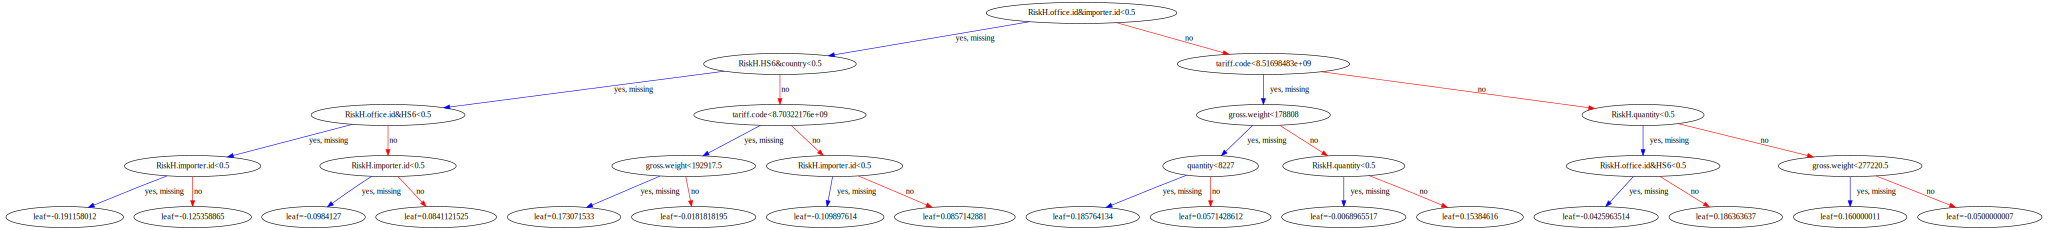

In [65]:
import xgboost as xgb
xgb.to_graphviz(booster = xgb_clf, num_trees=0)

In [66]:
# evaluate xgboost model
print("------Evaluating xgboost model------")
# Predict
test_pred = xgb_clf.predict_proba(xgb_testx)[:,1]
# Calculate auc
xgb_auc = roc_auc_score(xgb_testy, test_pred)
# Find the best threshold
xgb_threshold,_ = find_best_threshold(xgb_clf, xgb_validx, xgb_validy)
# Calculate the best f1 score
xgb_f1 = find_best_threshold(xgb_clf, xgb_testx, xgb_testy,best_thresh=xgb_threshold)
print("AUC = %.4f, F1-score = %.4f" % (xgb_auc, xgb_f1))

------Evaluating xgboost model------
F1-scre equals to:0.2054
AUC = 0.7498, F1-score = 0.2054


# Part 3. DATE model (XGB + Neural Networks + Attention) <a id='part3'></a>

## 3.1. Set environmenst

In [67]:
import argparse
import os
import pickle
import warnings
import time 
from collections import defaultdict

In [68]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data

In [69]:
from ranger import Ranger

## 3.2. Preprocessing data: Integer-encoding of IMPORTER.TIN and TARIFF.CODE for attention mechanism

In [71]:
# user & item information 
train_raw_importers = train['importer.id'].values
train_raw_items = train['tariff.code'].values
valid_raw_importers = valid['importer.id'].values
valid_raw_items = valid['tariff.code'].values
test_raw_importers = test['importer.id']
test_raw_items = test['tariff.code']

In [72]:
# we need padding for unseen user or item 
importer_set = set(train_raw_importers)
item_set = set(train_raw_items)

In [73]:
# Remember to +1 for zero padding 
importer_mapping = {v:i+1 for i,v in enumerate(importer_set)} 
hs6_mapping = {v:i+1 for i,v in enumerate(item_set)}
importer_size = len(importer_mapping) + 1
item_size = len(hs6_mapping) + 1
# label-encoding
train_importers = [importer_mapping[x] for x in train_raw_importers]
train_items = [hs6_mapping[x] for x in train_raw_items]

In [74]:
# for test data, we use padding_idx=0 for unseen data
# use dic.get(key,deafault) to handle unseen
valid_importers = [importer_mapping.get(x,0) for x in valid_raw_importers]
valid_items = [hs6_mapping.get(x,0) for x in valid_raw_items]
test_importers = [importer_mapping.get(x,0) for x in test_raw_importers] 
test_items = [hs6_mapping.get(x,0) for x in test_raw_items]

## 3.3. Define functions

### 3.3.1. "process_leaf_idx" function [(link to practice)](#practice5)

In [75]:
def process_leaf_idx(X_leaves): 
    '''
    This function is to convert the output of XGBoost model to the input of DATE model.
    For an individual import, the output of XGBoost model is a list of leaf index of multiple trees.
    eg. [1, 1, 10, 9, 30, 30, 32, ... ]
    How to distinguish "node 1" of the first tree from "node 1" of the second tree?
    How to distinguish "node 30" of the fifth tree from "node 30" of the sixth tree?
    This function is to assign unique index to every leaf node in all the trees. 
    This function returns;
    - lists of unique leaf index;
    - total number of unique leaf nodes; and
    - a reference table (dictionary) composed of "unique leaf index", "tree id", "(previous) leaf index". 
    '''
    leaves = X_leaves.copy()
    new_leaf_index = dict() # dictionary to store leaf index
    total_leaves = 0
    for c in range(X_leaves.shape[1]): # iterate for each column (ie. 100 trees)
        column = X_leaves[:,c]
        unique_vals = list(sorted(set(column)))
        new_idx = {v:(i+total_leaves) for i,v in enumerate(unique_vals)}
        for i,v in enumerate(unique_vals):
            leaf_id = i+total_leaves
            new_leaf_index[leaf_id] = {c:v}
        leaves[:,c] = [new_idx[v] for v in column]
        total_leaves += len(unique_vals)
        
    assert leaves.ravel().max() == total_leaves - 1
    return leaves,total_leaves,new_leaf_index

### 3.3.2. "fgsm_attack" function (Not used)

In [76]:
def fgsm_attack(model, loss, images, labels, eps) :
    # images.requires_grad = True
    images = Variable(images, requires_grad=True)
    outputs = model.module.pred_from_hidden(images)
    
    model.zero_grad()
    cost = loss(outputs, labels)
    cost.backward()
    attack_images = images + eps * images.grad.sign()
    return attack_images

### 3.3.3. "metrics" function

In [77]:
def metrics(y_prob,xgb_testy,revenue_test,best_thresh=None):
    if best_thresh ==None:
        _,overall_f1,auc = torch_threshold(y_prob,xgb_testy,best_thresh)
    else:
        overall_f1,auc = torch_threshold(y_prob,xgb_testy,best_thresh)
    
    pr, re, f, rev = [], [], [], []
    for i in [99,98,95,90]:
        threshold = np.percentile(y_prob, i)
        #print(f'Checking top {100-i}% suspicious transactions: {len(y_prob[y_prob > threshold])}')
        precision = np.mean(xgb_testy[y_prob > threshold])
        recall = sum(xgb_testy[y_prob > threshold])/sum(xgb_testy)
        f1 = 2*precision*recall/(precision+recall)
        revenue_recall = sum(revenue_test[y_prob > threshold]) /sum(revenue_test)

        # save results
        pr.append(precision)
        re.append(recall)
        f.append(f1)
        rev.append(revenue_recall)
        # print(f'Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, Seized Revenue (Recall): {round(revenue_recall, 4)}')
    return overall_f1,auc,pr, re, f, rev

### 3.3.4. "torch_threshold" function

In [78]:
def torch_threshold(y_pred_prob,y_test,best_thresh = None):
    '''
    This function is to find the best threshold to determine "to inspect" or "not".
    We assume that we inspect only the imports where predicted probability of fraud is above the threshold.
    '''
    threshold_list = np.arange(0.1,0.6,0.1)
    best_f1 = 0
    if best_thresh == None:
        for th in threshold_list:
            y_pred_label = (y_pred_prob > th)*1 
            f_score = f1_score(y_test,y_pred_label)
            if f_score > best_f1:
                best_f1 = f_score
                best_thresh = th 
        return best_thresh, best_f1, roc_auc_score(y_test, y_pred_prob)
    else:
        y_pred_label = (y_pred_prob > best_thresh)*1 
        best_f1 = f1_score(y_test,y_pred_label)
        return best_f1, roc_auc_score(y_test, y_pred_prob)

## 3.4. Identify leaf nodes of individual import from XGB model

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import  OneHotEncoder

# get leaf index from xgboost model 
X_train_leaves = xgb_clf.apply(xgb_trainx) #apply: Return the predicted leaf every tree for each sample.
X_valid_leaves = xgb_clf.apply(xgb_validx)
X_test_leaves = xgb_clf.apply(xgb_testx)
train_rows = X_train_leaves.shape[0]

In [80]:
# Preprocess
train_rows = train.shape[0]
valid_rows = valid.shape[0] + train_rows
X_leaves = np.concatenate((X_train_leaves, X_valid_leaves, X_test_leaves), axis=0) # make sure the dimensionality
transformed_leaves, leaf_num, new_leaf_index = process_leaf_idx(X_leaves)
train_leaves, valid_leaves, test_leaves = transformed_leaves[:train_rows],\
                                          transformed_leaves[train_rows:valid_rows],\
                                          transformed_leaves[valid_rows:]


## 3.5. Convert data to tensor
Tensor is a collection of numbers with specific shape (dimension)

In [81]:
# Convert to torch type
train_leaves = torch.tensor(train_leaves).long()
train_user = torch.tensor(train_importers).long()
train_item = torch.tensor(train_items).long()

valid_leaves = torch.tensor(valid_leaves).long()
valid_user = torch.tensor(valid_importers).long()
valid_item = torch.tensor(valid_items).long()

test_leaves = torch.tensor(test_leaves).long()
test_user = torch.tensor(test_importers).long()
test_item = torch.tensor(test_items).long()

# cls data
train_label_cls = torch.tensor(xgb_trainy).float()
valid_label_cls = torch.tensor(xgb_validy).float()
test_label_cls = torch.tensor(xgb_testy).float()

# revenue data 
train_label_reg = torch.tensor(norm_revenue_train).float()
valid_label_reg = torch.tensor(revenue_valid).float()
test_label_reg = torch.tensor(revenue_test).float()

# create dataloader 

train_dataset = Data.TensorDataset(train_leaves,train_user,train_item,train_label_cls,train_label_reg)
valid_dataset = Data.TensorDataset(valid_leaves,valid_user,valid_item,valid_label_cls,valid_label_reg)
test_dataset = Data.TensorDataset(test_leaves,test_user,test_item,test_label_cls,test_label_reg)



data4embedding = {"train_dataset":train_dataset,"valid_dataset":valid_dataset,"test_dataset":test_dataset,\
                  "leaf_num":leaf_num,"importer_num":importer_size,"item_size":item_size}

## 3.6. Save and load data

### 3.6.1. Save data

In [82]:
with open("torch_data.pickle", 'wb') as f:
    pickle.dump(data4embedding, f, protocol=pickle.HIGHEST_PROTOCOL)

with open("leaf_index.pickle", "wb") as f:
    pickle.dump(new_leaf_index, f, protocol=pickle.HIGHEST_PROTOCOL)

### 3.6.2. Load data

In [83]:
warnings.filterwarnings("ignore")

In [84]:
# load torch dataset 
with open("torch_data.pickle","rb") as f:
    data = pickle.load(f)

In [85]:
# get torch dataset 
train_dataset = data["train_dataset"]
valid_dataset = data["valid_dataset"]
test_dataset = data["test_dataset"]

In [86]:
# create dataloader
batch_size = 256
train_loader = Data.DataLoader(
    dataset=train_dataset,     
    batch_size=batch_size,      
    shuffle=True,               
)
valid_loader = Data.DataLoader(
    dataset=valid_dataset,     
    batch_size=batch_size,      
    shuffle=False,               
)
test_loader = Data.DataLoader(
    dataset=test_dataset,     
    batch_size=batch_size,      
    shuffle=False,               
)

# parameters for model 
leaf_num = data["leaf_num"]
importer_size = data["importer_num"]
item_size = data["item_size"]

# global variables
xgb_validy = valid_loader.dataset.tensors[-2].detach().numpy()
xgb_testy = test_loader.dataset.tensors[-2].detach().numpy()
revenue_valid = valid_loader.dataset.tensors[-1].detach().numpy()
revenue_test = test_loader.dataset.tensors[-1].detach().numpy()

# model information
curr_time = str(time.time())
model_name = "DATE"
model_path = "./saved_models/%s%s.pkl" % (model_name,curr_time)

## 3.7. Model construction

In [87]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import numpy as np 
from torch_multi_head_attention import MultiHeadAttention

[link to practice Mish()](#practice6)

In [88]:
class Mish(nn.Module):
    def __init__(self):
        super(Mish,self).__init__()
    def forward(self, x):
        return x *( torch.tanh(F.softplus(x))) #softplus???

[link to practice FusionAttention()](#practice7)

In [89]:
class FusionAttention(nn.Module):
    
    def __init__(self,dim):
        super(FusionAttention, self).__init__()
        self.attention_matrix = nn.Linear(dim, dim) # nn.Linear(size of input, size of output)
        self.project_weight = nn.Linear(dim,1)
        
    def forward(self, inputs):
        query_project = self.attention_matrix(inputs) # (b,t,d) -> (b,t,d2)
        query_project = F.leaky_relu(query_project)
        project_value = self.project_weight(query_project) # (b,t,h) -> (b,t,1)
        attention_weight = torch.softmax(project_value, dim=1) # Normalize and calculate weights (b,t,1)
        attention_vec = inputs * attention_weight
        attention_vec = torch.sum(attention_vec,dim=1)
        return attention_vec, attention_weight

[link to practice Attention()](#practice8)

In [90]:
class Attention(nn.Module):
    
    def __init__(self,dim,hidden,aggregate="sum"):
        super(Attention, self).__init__()
        self.attention_matrix = nn.Linear(dim, hidden)
        self.project_weight = nn.Linear(hidden*2,hidden)
        self.h = nn.Parameter(torch.rand(hidden,1))
        self.agg_type = aggregate
        
    def forward(self, query, key): # query: 256 X 16, # key: 256 X 100 X 16, # assume key==value
        dim = query.size(-1) # 16 (n_embedding_dimension)
        batch = key.size(0) # 256 (batch_size = n_observation in a batch)
        time_step = key.size(1) # 100 (n_trees from xgboot model)
        
        # concate input query and key 
        query = query.view(batch,1,dim) # view = reshape: (256X16) -> (256X1X16)
        query = query.expand(batch,time_step,-1) # expand to the same dimension: (256X1X16) -> (256X100X16)
        cat_vector = torch.cat((query,key),dim=-1) # (256X100X32)
        
        # project to single value
        project_vector = self.project_weight(cat_vector) 
        project_vector = torch.relu(project_vector)
        attention_alpha = torch.matmul(project_vector,self.h)
        attention_weight = torch.softmax(attention_alpha, dim=1) # Normalize and calculate weights (b,t,1)
        attention_vec = key * attention_weight
        
        # aggregate leaves
        if self.agg_type == "max":
            attention_vec,_ = torch.max(attention_vec,dim=1)
        elif self.agg_type =="mean":
            attention_vec = torch.mean(attention_vec,dim=1)
        elif self.agg_type =="sum":
            attention_vec = torch.sum(attention_vec,dim=1)
        return attention_vec, attention_weight

[link to practice DATE()](#practice9)

In [91]:
class DATE(nn.Module):
    
    def __init__(self,
                 max_leaf,importer_size,item_size,dim,
                 head_num=4,fusion_type="concat",act="relu",device="cpu",use_self=True,agg_type="sum"):
        super(DATE, self).__init__()
        self.d = dim
        self.device = device
        if act == "relu":
            self.act = nn.LeakyReLU()
        elif act == "mish":
            self.act = Mish() 
        self.fusion_type = fusion_type
        self.use_self = use_self

        # embedding layers 
        self.leaf_embedding = nn.Embedding(max_leaf,dim)
        self.user_embedding = nn.Embedding(importer_size,dim,padding_idx=0)
        self.user_embedding.weight.data[0] = torch.zeros(dim) # unseen data? initial value?
        self.item_embedding = nn.Embedding(item_size,dim,padding_idx=0)
        self.item_embedding.weight.data[0] = torch.zeros(dim)

        # attention layer
        self.attention_bolck = Attention(dim,dim,agg_type).to(device)
        self.self_att = MultiHeadAttention(dim,head_num).to(device)
        self.fusion_att = FusionAttention(dim)

        # Hidden & output layer
        self.layer_norm = nn.LayerNorm((100,dim))
        self.fussionlayer = nn.Linear(dim*3,dim)
        self.hidden = nn.Linear(dim,dim)
        self.output_cls_layer = nn.Linear(dim,1)
        self.output_reg_layer = nn.Linear(dim,1)
    
    def forward(self,feature,uid,item_id):
        
        # Embedding of leaf_id
        leaf_vectors = self.leaf_embedding(feature)
        
        # 1st attention: Multi-Head Self-Attention
        # Calculate the weight(importance) of each leaf(cross-feature) based on the correlation with other leafs
        if self.use_self:
            # Apply multy head attention
            leaf_vectors = self.self_att(leaf_vectors,leaf_vectors,leaf_vectors)
            # Normalization?
            leaf_vectors = self.layer_norm(leaf_vectors)
        
        # Embedding of importer_id
        importer_vector = self.user_embedding(uid)
        # Embedding of item_id
        item_vector = self.item_embedding(item_id)
        # Multiply embeddings of importer_id and item_id
        query_vector = importer_vector * item_vector
        
        # 2nd attention: Attention with leaf_id, importer_id and item_id (all embeddings)
        set_vector, self.attention_w = self.attention_bolck(query_vector,leaf_vectors)
        
        # concat the user, item and tree vectors into a fusion attention
        if self.fusion_type == "concat":
            fusion = torch.cat((importer_vector, item_vector, set_vector), dim=-1) # attach as columns
            fusion = self.act(self.fussionlayer(fusion))
        elif self.fusion_type == "attention":
            importer_vector=importer_vector.view(-1,1,self.d), 
            item_vector=item_vector.view(-1,1,self.d), 
            set_vector=set_vector.view(-1,1,self.d)
            fusion = torch.cat((importer_vector, item_vector, set_vector), dim=1) # attach as columns
            fusion,_ = self.fusion_att(fusion)
        else:
            raise "Fusion type error"
        hidden = self.hidden(fusion)
        hidden = self.act(hidden)

        # multi-task output 
        classification_output = torch.sigmoid(self.output_cls_layer(hidden))
        regression_output = torch.relu(self.output_reg_layer(hidden))
        return classification_output, regression_output, hidden

    def pred_from_hidden(self,hidden):
        classification_output = torch.sigmoid(self.output_cls_layer(hidden))
        return classification_output 

    def eval_on_batch(self,test_loader): # predict test data using batch 
        final_output = []
        cls_loss = []
        reg_loss = []
        for batch in test_loader:
            batch_feature, batch_user, batch_item, batch_cls, batch_reg = batch
            batch_feature,batch_user,batch_item,batch_cls,batch_reg =  \
            batch_feature.to(self.device), batch_user.to(self.device),\
            batch_item.to(self.device), batch_cls.to(self.device), batch_reg.to(self.device)
            batch_cls,batch_reg = batch_cls.view(-1,1), batch_reg.view(-1,1)
            y_pred_prob, y_pred_rev,_ = self.forward(batch_feature,batch_user,batch_item)

            # compute classification loss
            cls_losses = nn.BCELoss()(y_pred_prob,batch_cls)
            cls_loss.append(cls_losses.item())

            # compute regression loss 
            reg_losses = nn.MSELoss()(y_pred_rev, batch_reg)
            reg_loss.append(reg_losses.item())

            # store predicted probability 
            y_pred = y_pred_prob.detach().cpu().numpy().tolist()
            final_output.extend(y_pred)

        print("CLS loss: %.4f, REG loss: %.4f"% (np.mean(cls_loss), np.mean(reg_loss)) )
        return np.array(final_output).ravel(), np.mean(cls_loss)+ np.mean(reg_loss)


## 3.8. Train (hyperparameter + loss function)

### 3.8.1. Set hyperparameter

In [92]:
# Parse argument
parser = argparse.ArgumentParser()
parser.add_argument('--model_name', 
                        type=str, 
                        default="DATE", 
                        help="Name of model",
                        )
parser.add_argument('--epoch', 
                        type=int, 
                        default=5, 
                        help="Number of epochs",
                        )
parser.add_argument('--dim', 
                        type=int, 
                        default=16, 
                        help="Hidden layer dimension",
                        )
parser.add_argument('--lr', 
                        type=float, 
                        default=0.005, 
                        help="learning rate",
                        )
parser.add_argument('--l2',
                        type=float,
                        default=0.00,
                        help="l2 reg",
                        )
parser.add_argument('--alpha',
                        type=float,
                        default=10,
                        help="Regression loss weight",
                        )
parser.add_argument('--beta', type=float, default=0.00, help="Adversarial loss weight")
parser.add_argument('--head_num', type=int, default=4, help="Number of heads for self attention")
parser.add_argument('--use_self', type=int, default=1, help="Wheter to use self attention")
parser.add_argument('--fusion', type=str, choices=["concat","attention"], default="concat", help="Fusion method for final embedding")
parser.add_argument('--agg', type=str, choices=["sum","max","mean"], default="sum", help="Aggreate type for leaf embedding")
parser.add_argument('--act', type=str, choices=["mish","relu"], default="relu", help="Activation function")
parser.add_argument('--device', type=str, choices=["cuda:0","cuda:1","cpu"], default="cuda:0", help="device name for training")
parser.add_argument('--output', type=str, default="full.csv", help="Name of output file")
parser.add_argument('--save', type=int, default=0, help="save model or not")

_StoreAction(option_strings=['--save'], dest='save', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, help='save model or not', metavar=None)

In [93]:
args = parser.parse_args([])
# Refer to: https://stackoverflow.com/questions/50763033/argparse-in-jupyter-notebook-throws-a-typeerror

### 3.8.2. Train

In [97]:
def train(args):
    # get configs
    epochs = 20 #args.epoch
    dim = args.dim
    lr = args.lr
    weight_decay = args.l2
    head_num = args.head_num
    device = 'cuda:0'  #'cpu' if you run this code on cpu    #args.device
    act = args.act
    fusion = args.fusion
    beta = args.beta
    alpha = args.alpha
    use_self = args.use_self
    agg = args.agg
    model = DATE(leaf_num,importer_size,item_size,\
                                    dim,head_num,\
                                    fusion_type=fusion,act=act,device=device,\
                                    use_self=use_self,agg_type=agg,
                                    ).to(device)
    model = nn.DataParallel(model,device_ids=[0,1])

    # initialize parameters
    # Fills the input Tensor with values according to the method described in 
    # Understanding the difficulty of training deep feedforward neural networks - Glorot, X. & Bengio, Y. (2010), 
    # using a uniform distribution.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    # optimizer & loss 
    optimizer = Ranger(model.parameters(), weight_decay=weight_decay,lr=lr)
    cls_loss_func = nn.BCELoss()
    reg_loss_func = nn.MSELoss()

    # save best model
    global_best_score = 0
    model_state = None

    # early stop settings 
    stop_rounds = 3
    no_improvement = 0
    current_score = None 

    for epoch in range(epochs):
        for step, (batch_feature,batch_user,batch_item,batch_cls,batch_reg) in enumerate(train_loader):
            model.train() # prep to train model
            batch_feature,batch_user,batch_item,batch_cls,batch_reg =  \
            batch_feature.to(device), batch_user.to(device), batch_item.to(device),\
             batch_cls.to(device), batch_reg.to(device)
            batch_cls,batch_reg = batch_cls.view(-1,1), batch_reg.view(-1,1)

            # model output
            classification_output, regression_output, hidden_vector = model(batch_feature,batch_user,batch_item)

            # FGSM attack
            adv_vector = fgsm_attack(model,cls_loss_func,hidden_vector,batch_cls,0.01)
            adv_output = model.module.pred_from_hidden(adv_vector) 

            # calculate loss
            adv_loss_func = nn.BCELoss(weight=batch_cls) 
            adv_loss = beta * adv_loss_func(adv_output,batch_cls) 
            cls_loss = cls_loss_func(classification_output,batch_cls)
            revenue_loss = alpha * reg_loss_func(regression_output, batch_reg)
            loss = cls_loss + revenue_loss + adv_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (step+1) % 1000 ==0:  
                print("CLS loss:%.4f, REG loss:%.4f, ADV loss:%.4f, Loss:%.4f"\
                %(cls_loss.item(),revenue_loss.item(),adv_loss.item(),loss.item()))
                
        # evaluate 
        model.eval()
        print("Validate at epoch %s"%(epoch+1))
        y_prob, val_loss = model.module.eval_on_batch(valid_loader)
        y_pred_tensor = torch.tensor(y_prob).float().to(device)
        best_threshold, val_score, roc = torch_threshold(y_prob,xgb_validy)
        overall_f1, auc, precisions, recalls, f1s, revenues = metrics(y_prob,xgb_validy,revenue_valid)
        select_best = np.mean(f1s)
        print("Over-all F1:%.4f, AUC:%.4f, F1-top:%.4f" % (overall_f1, auc, select_best) )

        print("Evaluate at epoch %s"%(epoch+1))
        y_prob, val_loss = model.module.eval_on_batch(test_loader)
        y_pred_tensor = torch.tensor(y_prob).float().to(device)
        overall_f1, auc, precisions, recalls, f1s, revenues = metrics(y_prob,xgb_testy,revenue_test,best_thresh=best_threshold)
        print("Over-all F1:%.4f, AUC:%.4f, F1-top:%.4f" %(overall_f1, auc, np.mean(f1s)) )

        # save best model 
        if select_best > global_best_score:
            global_best_score = select_best
            torch.save(model,model_path)
        
         # early stopping 
        if current_score == None:
            current_score = select_best
            continue
        if select_best < current_score:
            current_score = select_best
            no_improvement += 1
        if no_improvement >= stop_rounds:
            print("Early stopping...")
            break 
        if select_best > current_score:
            no_improvement = 0
            current_score = None

In [98]:
train(args)

Validate at epoch 1
CLS loss: 0.2571, REG loss: 105252.8187
Over-all F1:0.2153, AUC:0.7950, F1-top:0.1351
Evaluate at epoch 1
CLS loss: 0.2610, REG loss: 116774.4090
Over-all F1:0.2146, AUC:0.7929, F1-top:0.1395
Validate at epoch 2
CLS loss: 0.2849, REG loss: 105255.6288
Over-all F1:0.1656, AUC:0.7851, F1-top:0.1261
Evaluate at epoch 2
CLS loss: 0.2921, REG loss: 116777.0393
Over-all F1:0.1719, AUC:0.7777, F1-top:0.1319
Validate at epoch 3
CLS loss: 0.2854, REG loss: 105251.8487
Over-all F1:0.2053, AUC:0.7533, F1-top:0.1340
Evaluate at epoch 3
CLS loss: 0.2933, REG loss: 116773.7773
Over-all F1:0.2044, AUC:0.7469, F1-top:0.1339
Validate at epoch 4
CLS loss: 0.3214, REG loss: 105246.4218
Over-all F1:0.2114, AUC:0.7278, F1-top:0.1317
Evaluate at epoch 4
CLS loss: 0.3335, REG loss: 116768.9343
Over-all F1:0.2115, AUC:0.7187, F1-top:0.1297
Validate at epoch 5
CLS loss: 0.3577, REG loss: 105257.8718
Over-all F1:0.1085, AUC:0.7127, F1-top:0.1311
Evaluate at epoch 5
CLS loss: 0.3704, REG loss

# Part 4. Evaluation <a id='part4'></a>

In [99]:
def evaluate(save_model):
    print()
    print("--------Evaluating DATE model---------")
    # create best model
    best_model = torch.load(model_path)
    best_model.eval()

    # get threshold
    y_prob, val_loss = best_model.module.eval_on_batch(valid_loader)
    best_threshold, val_score, roc = torch_threshold(y_prob,xgb_validy)

    # predict test 
    y_prob, val_loss = best_model.module.eval_on_batch(test_loader)
    overall_f1, auc, precisions, recalls, f1s, revenues = metrics(y_prob,xgb_testy,revenue_test,best_threshold)
    best_score = f1s[0]
    #os.system("rm %s"%model_path)
    if save_model:
        scroed_name = "./saved_models/%s_%.4f.pkl" % (model_name,overall_f1)
        torch.save(best_model,scroed_name)
    
    return overall_f1, auc, precisions, recalls, f1s, revenues

In [100]:
overall_f1, auc, precisions, recalls, f1s, revenues = evaluate(model_path)


--------Evaluating DATE model---------
CLS loss: 0.2571, REG loss: 105252.8187
CLS loss: 0.2610, REG loss: 116774.4090


In [101]:
# save result
output_file =  "./results/full.csv"
print("Saving result...",output_file)
with open(output_file, 'a') as ff:
    # print(args,file=ff)
    print()
    print("""Metrics:\nf1:%.4f auc:%.4f\nPr@1:%.4f Pr@2:%.4f Pr@5:%.4f Pr@10:%.4f\nRe@1:%.4f Re@2:%.4f Re@5:%.4f Re@10:%.4f\nRev@1:%.4f Rev@2:%.4f Rev@5:%.4f Rev@10:%.4f""" \
          % (overall_f1, auc,\
             precisions[0],precisions[1],precisions[2],precisions[3],\
             recalls[0],recalls[1],recalls[2],recalls[3],\
             revenues[0],revenues[1],revenues[2],revenues[3]
            ),
        ) 
    output_metric = [16,overall_f1,auc] + precisions + recalls + revenues
    output_metric = list(map(str,output_metric))
    print(" ".join(output_metric),file=ff)
        
    # print("Model:%s epoch:%d dim:%d lr:%f l2:%f beta:%f heads:%d fusion:%s activation:%s"
    #       % (model_name, epochs, dim, lr, weight_decay, beta, head_num,fusion,act),file=ff) 
    # print("""Metrics:\nf1:%.4f auc:%.4f\nPr@1:%.4f Pr@2:%.4f Pr@5:%.4f Pr@10:%.4f\nRe@1:%.4f Re@2:%.4f Re@5:%.4f Re@10:%.4f\nRev@1:%.4f Rev@2:%.4f Rev@5:%.4f Rev@10:%.4f"""  \
    #       % (overall_f1, auc,\
    #          precisions[0],precisions[1],precisions[2],precisions[3],\
    #          recalls[0],recalls[1],recalls[2],recalls[3],\
    #          revenues[0],revenues[1],revenues[2],revenues[3]
    #          ),
    #          file=ff)  

Saving result... ./results/full.csv

Metrics:
f1:0.2146 auc:0.7929
Pr@1:0.2350 Pr@2:0.2100 Pr@5:0.1920 Pr@10:0.2320
Re@1:0.0309 Re@2:0.0552 Re@5:0.1262 Re@10:0.3051
Rev@1:0.0333 Rev@2:0.0584 Rev@5:0.1268 Rev@10:0.3152


# Part 5. Practice of functions <a id='part5'></a>

## merge_attributes <a id='practice1'></a>

In [104]:
# make a small data for the demonstration.
df_sample = df.sample(3)
merge_attributes(df_sample, 'tariff.code','country')
df_sample

,sgd.date,office.id,importer.id,declarant.id,tariff.code,country,cif.value,quantity,gross.weight,total.taxes,revenue,illicit,tariff.code&country
85303,13-11-18,OFFICE59,IMP648653,DEC5544,8703241128,CNTRY759,8335,4,14344,4188,0,0,8703241128CNTRY759
83064,13-11-08,OFFICE81,IMP617843,DEC9556,8703210011,CNTRY939,3398,63,92044,188,0,0,8703210011CNTRY939
25070,13-04-19,OFFICE92,IMP606401,DEC1200,9505900000,CNTRY825,1477,3,852,700,0,0,9505900000CNTRY825


In [105]:
del df_sample

You can identify that new column "TARIFF.CODE&ORIGIN.CODE" has been created.  
You can learn each step of the function by replicating the codes line by line as follows;

In [107]:
df_sample = df.sample(3)
print('Check what happens from "iterables = [df[arg].astype(str) for arg in args]"\n=====')
iterables = [df_sample[arg].astype(str) for arg in ['tariff.code','country']] 
print(iterables)
print('')
print('Check what happens from "zip(*iterables)"\n=====')
print(list(zip(*iterables)))
print('')
print('What happens from "fs = [''.join([v for v in var]) for var in zip(*iterables)]" - part1\n=====')
print(list(var for var in zip(*iterables)))
print('')
print('What happens from "fs = [''.join([v for v in var]) for var in zip(*iterables)]" - part2\n=====')
fs = [''.join([v for v in var]) for var in zip(*iterables)]
print(fs)
print('')
print('What happens from "columnName = \'&\'.join([*args])\'&\'.join([*args])"\n=====')
columnName = '&'.join(['tariff.code','country'])
print(columnName)
print('')
df_sample.loc[:, columnName] = fs
print('df_sample[columnName]\n=====')
print(df_sample[columnName])

# Now, we finish the line-by-line practice of the "merge_attributes" fuction, and delete temporarily created data. 

del df_sample, iterables, fs

Check what happens from "iterables = [df[arg].astype(str) for arg in args]"
=====
[88531    4203300000
58655    8703241128
7861     4115100000
Name: tariff.code, dtype: object, 88531    CNTRY915
58655    CNTRY759
7861     CNTRY759
Name: country, dtype: object]

Check what happens from "zip(*iterables)"
=====
[('4203300000', 'CNTRY915'), ('8703241128', 'CNTRY759'), ('4115100000', 'CNTRY759')]

What happens from "fs = [.join([v for v in var]) for var in zip(*iterables)]" - part1
=====
[('4203300000', 'CNTRY915'), ('8703241128', 'CNTRY759'), ('4115100000', 'CNTRY759')]

What happens from "fs = [.join([v for v in var]) for var in zip(*iterables)]" - part2
=====
['4203300000CNTRY915', '8703241128CNTRY759', '4115100000CNTRY759']

What happens from "columnName = '&'.join([*args])'&'.join([*args])"
=====
tariff.code&country

df_sample[columnName]
=====
88531    4203300000CNTRY915
58655    8703241128CNTRY759
7861     4115100000CNTRY759
Name: tariff.code&country, dtype: object


## Preprocess <a id='practice2'></a>

In [108]:
df_sample = df.sample(3)
df_sample = preprocess(df_sample)
df_sample

,sgd.date,office.id,importer.id,declarant.id,tariff.code,country,cif.value,quantity,gross.weight,total.taxes,revenue,illicit,Unitprice,WUnitprice,TaxRatio,TaxUnitquantity,HS6,HS4,HS2,HS6&country,office.id&importer.id,office.id&HS6,office.id&country,SGD.DayofYear,SGD.WeekofYear,SGD.MonthofYear
56241,13-08-14,OFFICE92,IMP894296,DEC7484,8714190000,CNTRY680,92274,4,1694,8431,0,0,23068.500000,54.471074,0.091369,2107.750000,871419,8714,87,871419CNTRY680,OFFICE92IMP894296,OFFICE92871419,OFFICE92CNTRY680,225,32,7
13932,13-03-06,OFFICE40,IMP759377,DEC8223,8703321922,CNTRY759,34342,17,415700,3661,0,0,2020.117647,0.082612,0.106604,215.352941,870332,8703,87,870332CNTRY759,OFFICE40IMP759377,OFFICE40870332,OFFICE40CNTRY759,64,9,2
79713,13-10-29,OFFICE40,IMP749280,DEC9870,2106901000,CNTRY653,3194,818,1008,458,0,0,3.904645,3.168651,0.143394,0.559902,210690,2106,21,210690CNTRY653,OFFICE40IMP749280,OFFICE40210690,OFFICE40CNTRY653,301,43,10


In [109]:
del df_sample

## find_risk_profile <a id='practice3'></a>

In [111]:
df_sample = df.sample(100)

# We will identify top 10% of high risk importers in terms of its non-compliance records. 
find_risk_profile(df=df_sample, feature='importer.id', topk_ratio=0.1, adj=10, option='topk')

['IMP243487',
 'IMP264340',
 'IMP692823',
 'IMP913967',
 'IMP505713',
 'IMP865586',
 'IMP355376',
 'IMP358915',
 'IMP361374',
 'IMP366360']

In [112]:
del df_sample

## tag_risky_profiles <a id='practice4'></a>

In [113]:
# Make a sample data
df_sample = df.sample(100)
# Identify top 10% high-risk importer
risk_profiles = find_risk_profile(df_sample, 'importer.id', 0.1, 10, option='topk')
risk_profiles

['IMP221442',
 'IMP317314',
 'IMP606401',
 'IMP643025',
 'IMP783306',
 'IMP438805',
 'IMP225876',
 'IMP412513',
 'IMP358915',
 'IMP359656']

In [115]:
# Tag "RiskH" to the top 10% high-risk importers
aaa = tag_risky_profiles(df=df_sample, profile='importer.id', profiles=risk_profiles, option='topk')
aaa.sort_values('RiskH.importer.id', ascending=False)

,sgd.date,office.id,importer.id,declarant.id,tariff.code,country,cif.value,quantity,gross.weight,total.taxes,revenue,illicit,RiskH.importer.id
97391,13-12-23,OFFICE40,IMP606401,DEC3641,8516800000,CNTRY415,3577,1,565,510,1442,1,1
38968,13-06-11,OFFICE51,IMP359656,DEC8254,8703321922,CNTRY680,8124,1,25077,4141,0,0,1
93071,13-12-09,OFFICE59,IMP358915,DEC6350,8703321922,CNTRY680,4365,4,1993,4381,0,0,1
31041,13-05-13,OFFICE76,IMP412513,DEC3474,8704322000,CNTRY454,6729,1,8557,3222,0,0,1
5849,13-01-29,OFFICE60,IMP317314,DEC8824,8210000000,CNTRY859,4051,596,206579,4163,336,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10500,13-02-18,OFFICE76,IMP322276,DEC3949,8703332100,CNTRY615,4616,1342,236012,2690,0,0,0
70057,13-09-30,OFFICE60,IMP891508,DEC1704,9022120000,CNTRY874,1841,1,8582,726,0,0,0
49383,13-07-17,OFFICE59,IMP839288,DEC5426,8703241128,CNTRY680,271655,1,376516,62042,0,0,0
92026,13-12-05,OFFICE76,IMP992026,DEC2777,8517180000,CNTRY759,9305,1,504647,3772,0,0,0


In [116]:
del df_sample, aaa

## process_leaf_idx <a id='practice5'></a>

In [117]:
df_sample = X_train_leaves[:3] # 100 trees in our xgboost model!
df_sample

array([[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 13, 15, 15, 13, 13, 13,
        13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 17, 23, 15, 23, 17, 15,
        17, 15, 15, 19, 15, 25, 15, 15, 15, 20, 17, 15, 16, 28, 15, 15,
        17, 16, 16, 15, 17, 15, 21, 20, 15, 15, 20, 15, 17, 21, 15, 19,
        16, 25, 16, 16, 18, 15, 15, 19, 22, 17, 17, 19, 17, 15, 16, 18,
        19, 18, 19, 16, 16, 18, 18, 29, 15, 16, 21, 20, 17, 18, 16, 18,
        16, 23, 15, 18],
       [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 13, 15, 15, 13, 13, 13,
        13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 17, 23, 15, 23, 17, 15,
        17, 15, 15, 19, 15, 25, 15, 15, 15, 20, 17, 15, 16, 28, 15, 15,
        17, 16, 16, 15, 17, 15, 21, 20, 15, 15, 20, 15, 17, 21, 15, 20,
        16, 15, 16, 16, 18, 15, 15, 19, 22, 15, 18, 20, 17, 15, 16, 19,
        19, 18, 15, 20, 15, 18, 19, 29, 15, 19, 18, 23, 15, 21, 13, 18,
        23, 23, 15, 18],
       [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 13, 15, 15, 13, 13, 13,
        13, 15

In [118]:
leaves, total_leaves, new_leaf_index = process_leaf_idx(df_sample)

In [119]:
# new idex of leaf
leaves

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  65,
         67,  69,  70,  71,  72,  73,  74,  75,  77,  79,  81,  83,  84,
         85,  86,  88,  89,  91,  93,  96,  97,  98, 100, 101, 102, 106,
        108, 111, 112, 115, 116, 117, 119, 120, 121],
       [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  64,  65,
         66,  69,  70,  71,  72,  73,  74,  75,  76,  80,  82,  83,  8

In [120]:
total_leaves

122

In [121]:
# Reference: {new_leaf_index: {tree_index: leaf_index}}
new_leaf_index

{0: {0: 15},
 1: {1: 15},
 2: {2: 15},
 3: {3: 15},
 4: {4: 15},
 5: {5: 15},
 6: {6: 15},
 7: {7: 15},
 8: {8: 15},
 9: {9: 15},
 10: {10: 13},
 11: {11: 15},
 12: {12: 15},
 13: {13: 13},
 14: {14: 13},
 15: {15: 13},
 16: {16: 13},
 17: {17: 15},
 18: {18: 15},
 19: {19: 15},
 20: {20: 15},
 21: {21: 15},
 22: {22: 15},
 23: {23: 15},
 24: {24: 15},
 25: {25: 15},
 26: {26: 17},
 27: {27: 23},
 28: {28: 15},
 29: {29: 23},
 30: {30: 17},
 31: {31: 15},
 32: {32: 17},
 33: {33: 15},
 34: {34: 15},
 35: {35: 19},
 36: {36: 15},
 37: {37: 25},
 38: {38: 15},
 39: {39: 15},
 40: {40: 15},
 41: {41: 20},
 42: {42: 17},
 43: {43: 15},
 44: {44: 16},
 45: {45: 28},
 46: {46: 15},
 47: {47: 15},
 48: {48: 17},
 49: {49: 16},
 50: {50: 16},
 51: {51: 15},
 52: {52: 17},
 53: {53: 15},
 54: {54: 21},
 55: {55: 20},
 56: {56: 15},
 57: {57: 15},
 58: {58: 20},
 59: {59: 15},
 60: {60: 17},
 61: {61: 21},
 62: {62: 15},
 63: {63: 19},
 64: {63: 20},
 65: {64: 16},
 66: {65: 15},
 67: {65: 25},


In [122]:
del df_sample, leaves, total_leaves, new_leaf_index

## Mish <a id='practice6'></a>

In [123]:
x = torch.rand((1,3))
Mish_test = Mish()
print("x: ", x,"Mish(x): ", Mish_test(x))

x:  tensor([[0.5517, 0.7971, 0.1953]]) Mish(x):  tensor([[0.4217, 0.6568, 0.1292]])


## FusionAttention <a id='practice7'></a>

In [124]:
print('0. Set an arbitrary imput data\n=====')
inputs_test = torch.randn(256,3,16)
print(inputs_test.shape)
dim_test=inputs_test.shape[-1]
print('')
print("1. query_project \n==============")
query_project = nn.Linear(dim_test,dim_test)(inputs_test)
print(query_project.shape)
print('')
print("2. query_project \n==============")
query_project = F.leaky_relu(query_project)
print(query_project.shape)
print('')
print("3. project_value \n==============")
project_value = nn.Linear(dim_test,1)(query_project)
print(project_value.shape)
print('')
print("4. attention_weight \n==============")
attention_weight = torch.softmax(project_value, dim=1)
print(attention_weight.shape)
print('')
print("5. attention_vec \n==============")
attention_vec = inputs_test*attention_weight
print(attention_vec.shape)
print('')
print("6. attention_vec \n==============")
attention_vec = torch.sum(attention_vec, dim=1)
print(attention_vec.shape)

0. Set an arbitrary imput data
=====
torch.Size([256, 3, 16])

1. query_project 
torch.Size([256, 3, 16])

2. query_project 
torch.Size([256, 3, 16])

3. project_value 
torch.Size([256, 3, 1])

4. attention_weight 
torch.Size([256, 3, 1])

5. attention_vec 
torch.Size([256, 3, 16])

6. attention_vec 
torch.Size([256, 16])


## Attention <a id='practice8'></a>

In [125]:
print('1. Set arbitrary "query" and "key"\n=====')
# "query" is the embedding layer of importer_id + HScode_id in the final model.
# "key" is the embedding layer of leaf_id of 100 decision trees in the final model.
query = torch.randn(256, 16) # (batch_size, n_embedding_dim)
print('query:',query.shape)
key = torch.randn(256, 100, 16) # (batch_size, n_trees, n_embedding_dim)
print('key:',key.shape)
print('')
print('2. Transform "quary" to be merged with "key"\n=====')
dim = query.size(-1) # 16 (n_embedding_dimension)
batch = key.size(0) # 256 (batch_size = n_observation in a batch)
time_step = key.size(1) # 100 (n_trees from xgboot model)
query = query.view(batch,1,dim) # view = reshape: (256X16) -> (256X1X16)
query = query.expand(batch,time_step,-1) # expand to the same dimension: (256X1X16) -> (256X100X16)
print('query:', query.shape)
cat_vector = torch.cat((query,key),dim=-1) # (256X100X32)
print('cat_vector:',cat_vector.shape)
print('')
print('3. Neural Network\n=====')
project_vector = nn.Linear(32,16)(cat_vector)
print('3-1. project_vector:',project_vector.shape)
project_vector = torch.relu(project_vector)
print('3-2. project_vector:',project_vector.shape)
h = nn.Parameter(torch.rand(16,1))
print('3-3. h:',h.shape)
attention_alpha = torch.matmul(project_vector,h)
attention_weight = torch.softmax(attention_alpha, dim=1) # Normalize and calculate weights (b,t,1)
print('3-4. attention_weight:',attention_weight.shape)
attention_vec = key * attention_weight # assumed 'key'=='value'
print('3-5. attention_vec:',attention_vec.shape)
print('')
print('4. Result\n=====')
max_attention_vec,_ = torch.max(attention_vec,dim=1)
print('4-1. max_attention_vec:',max_attention_vec.shape)
mean_attention_vec = torch.mean(attention_vec,dim=1)
print('4-2. mean_attention_vec:',mean_attention_vec.shape)
sum_attention_vec = torch.sum(attention_vec,dim=1)
print('4-3. sum_attention_vec:',sum_attention_vec.shape)

1. Set arbitrary "query" and "key"
=====
query: torch.Size([256, 16])
key: torch.Size([256, 100, 16])

2. Transform "quary" to be merged with "key"
=====
query: torch.Size([256, 100, 16])
cat_vector: torch.Size([256, 100, 32])

3. Neural Network
=====
3-1. project_vector: torch.Size([256, 100, 16])
3-2. project_vector: torch.Size([256, 100, 16])
3-3. h: torch.Size([16, 1])
3-4. attention_weight: torch.Size([256, 100, 1])
3-5. attention_vec: torch.Size([256, 100, 16])

4. Result
=====
4-1. max_attention_vec: torch.Size([256, 16])
4-2. mean_attention_vec: torch.Size([256, 16])
4-3. sum_attention_vec: torch.Size([256, 16])


## DATE model <a id='practice9'></a>

In [126]:
device = 'cpu'
head_num = 4

print('1. Hyperparameters\n=====')
print('dim:',dim)
print('leaf_num:',leaf_num)
print('device:',device)
print('item_size:',item_size)
print('importer_size:',importer_size)
print('')
print('2. Toy data (batch)\n=====\none batch from \'train_loader\'')
feature,uid,item_id,cls,reg = next(iter(train_loader))
print('feature:',feature.shape)
print('uid:',uid.shape)
print('item_id:',item_id.shape)
# other option
#feature = train_loader.dataset.tensors[0][:256]
#uid = train_loader.dataset.tensors[1][:256]
#item_id = train_loader.dataset.tensors[2][:256]
print('')
print('3. Embedding of feature (cross-features, leaf_ids)\n=====')
leaf_vectors = nn.Embedding(leaf_num,dim)(feature)
print('leaf_vectors:',leaf_vectors.shape)
print('')
print('4. Multi-Head Self-Attention (1st attention) \n=====')
# Calculate the weight(importance) of each leaf(cross-feature) based on the correlation with other leafs
# Apply multy head attention
multiheadattention = MultiHeadAttention(dim,head_num).to(device)
leaf_vectors = multiheadattention(leaf_vectors,leaf_vectors,leaf_vectors)
print(leaf_vectors.shape)
leaf_vectors = nn.LayerNorm((100,dim))(leaf_vectors)
print(leaf_vectors.shape)
print('')
print('5. Embedding of importer_id\n=====')
importer_vector = nn.Embedding(importer_size,dim,padding_idx=0)(uid)
print(importer_vector.shape)
print('')
print('6. Embedding of item_id(HScode)\n=====')
item_vector = nn.Embedding(item_size,dim,padding_idx=0)(item_id)
print(item_vector.shape)
print(' ')
print('7. Multiply embeddings of importer_id and item_id\n=====')
query_vector = importer_vector * item_vector
print(query_vector.shape)
print(' ')
print('8. Attention with leaf_id, importer_id and item_id (2nd attention)\n=====')
attention = Attention(dim,dim,"sum").to(device)
set_vector, _ = attention(query_vector,leaf_vectors)
print(set_vector.shape)
print('')
print('9. Concat the user_id, item_id and set(attention)_vector to fusion\n=====')
importer_vector=importer_vector.view(-1,1,dim)
print('importer_vector:',importer_vector.shape)
item_vector=item_vector.view(-1,1,dim) 
print('item_vector:',item_vector.shape)
set_vector=set_vector.view(-1,1,dim)
print('set_vector:',set_vector.shape)
fusion = torch.cat((importer_vector, item_vector, set_vector), dim=1) # attach as columns
print('fusion:', fusion.shape)
print('')
print('10. Fusion Attention\n=====')
fusion_att = FusionAttention(dim)
fusion,_ = fusion_att(fusion) # fusion attention
print('fusion:',fusion.shape)
print('')
print('11. Task-specific layers\n=====')
hidden = nn.Linear(dim,dim)(fusion)
hidden = nn.LeakyReLU()(hidden)
print('hidden:',hidden.shape)
print('')
print('12. output\n=====')
classification_output = torch.sigmoid(nn.Linear(dim,1)(hidden))
print('classification_output:',classification_output.shape)
regression_output = torch.relu(nn.Linear(dim,1)(hidden))
print('regression_output:',regression_output.shape)

1. Hyperparameters
=====
dim: 16
leaf_num: 1516
device: cpu
item_size: 1877
importer_size: 7342

2. Toy data (batch)
=====
one batch from 'train_loader'
feature: torch.Size([256, 100])
uid: torch.Size([256])
item_id: torch.Size([256])

3. Embedding of feature (cross-features, leaf_ids)
=====
leaf_vectors: torch.Size([256, 100, 16])

4. Multi-Head Self-Attention (1st attention) 
=====
torch.Size([256, 100, 16])
torch.Size([256, 100, 16])

5. Embedding of importer_id
=====
torch.Size([256, 16])

6. Embedding of item_id(HScode)
=====
torch.Size([256, 16])
 
7. Multiply embeddings of importer_id and item_id
=====
torch.Size([256, 16])
 
8. Attention with leaf_id, importer_id and item_id (2nd attention)
=====
torch.Size([256, 16])

9. Concat the user_id, item_id and set(attention)_vector to fusion
=====
importer_vector: torch.Size([256, 1, 16])
item_vector: torch.Size([256, 1, 16])
set_vector: torch.Size([256, 1, 16])
fusion: torch.Size([256, 3, 16])

10. Fusion Attention
=====
fusion: torc

# Annex: XGBoost and Logistic Regression <a id='part6'></a>

## A.1. Performance of XGBoost model
Performance indicators;
- precision = (number of seizures)/(number of inspections) --> targeting accuracy
- recall = (number of seizures)/(number of actual frauds)
- revenue_recall = (revenue from seizures)/(revenue from actual frauds)

In [127]:
# Precision and Recall
y_prob = test_pred
for i in [99,98,95,90]:
    # Find the ith value in ascending order.
    threshold = np.percentile(y_prob, i)
    print(f'Checking top {100-i}% suspicious transactions: {len(y_prob[y_prob > threshold])}')
    precision = np.mean(xgb_testy[y_prob > threshold])
    recall = sum(xgb_testy[y_prob > threshold])/sum(xgb_testy)
    revenue_recall = sum(revenue_test[y_prob > threshold]) /sum(revenue_test)
    print(f'Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, Seized Revenue (Recall): {round(revenue_recall, 4)}')

Checking top 1% suspicious transactions: 200
Precision: 0.20499999821186066, Recall: 0.027, Seized Revenue (Recall): 0.0314
Checking top 2% suspicious transactions: 400
Precision: 0.20250000059604645, Recall: 0.0533, Seized Revenue (Recall): 0.0546
Checking top 5% suspicious transactions: 1000
Precision: 0.1889999955892563, Recall: 0.1243, Seized Revenue (Recall): 0.1255
Checking top 10% suspicious transactions: 2000
Precision: 0.19050000607967377, Recall: 0.2505, Seized Revenue (Recall): 0.2686


In [128]:
# Save the structured trees in txt file
xgb_clf.get_booster().dump_model('xgb_model.txt', with_stats=False)

## A.2. XGBoost + Logistic Regression model <a id='part3'></a>

### A.2.1. Deploy Xgboost+LR model 
Summary
    1. Apply the pre-trained XGBoost model to train-, valid- and test-data. 
    2. For an individual import, the XGBoost model returns a list of leaf index of the multiple trees. 
    3. One-hot-encode leaf node.
    4. The encoded leaf index is fed as an input into the logistic regression model. 

1. Apply the pre-trained XGBoost model to train-, valid- and test-data.

In [129]:
# Xgboost+LR model 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import  OneHotEncoder

# get leaf index from xgboost model 
X_train_leaves = xgb_clf.apply(xgb_trainx) #apply: Return the predicted leaf every tree for each sample.
X_valid_leaves = xgb_clf.apply(xgb_validx)
X_test_leaves = xgb_clf.apply(xgb_testx)
train_rows = X_train_leaves.shape[0]

2. For an individual import, the XGBoost model returns a list of leaf index of the multiple trees.

In [130]:
# Print the 100 leaf nodes of the first import in the train-data
X_train_leaves[0]

array([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 13, 15, 15, 13, 13, 13, 13,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 17, 23, 15, 23, 17, 15, 17, 15,
       15, 19, 15, 25, 15, 15, 15, 20, 17, 15, 16, 28, 15, 15, 17, 16, 16,
       15, 17, 15, 21, 20, 15, 15, 20, 15, 17, 21, 15, 19, 16, 25, 16, 16,
       18, 15, 15, 19, 22, 17, 17, 19, 17, 15, 16, 18, 19, 18, 19, 16, 16,
       18, 18, 29, 15, 16, 21, 20, 17, 18, 16, 18, 16, 23, 15, 18],
      dtype=int32)

3. One-hot-encode the leaf (Create unique set of 0s and 1s for individual leaf index).
For instance, 
    - Leaf index 1: [100000...00]
    - Leaf index 2: [010000...00]
    - Leaf index 3: [001000...00]
    - ...

In [131]:
# one-hot encoding for leaf index
xgbenc = OneHotEncoder(categories="auto")
lr_trainx = xgbenc.fit_transform(X_train_leaves)
lr_validx = xgbenc.transform(X_valid_leaves)
lr_testx = xgbenc.transform(X_test_leaves)

4. Input the encoded leaf index into the logistic regression model. 

In [132]:
# model 
print("Training Logistic regression model...")
lr = LogisticRegression(n_jobs=-1)
lr.fit(lr_trainx, xgb_trainy)
test_pred = lr.predict_proba(lr_testx)[:,1]
print("------Evaluating xgboost+LR model------")
xgb_auc = roc_auc_score(xgb_testy, test_pred)
xgb_threshold,_ = find_best_threshold(lr, lr_validx, xgb_validy) # threshold was select from validation set
xgb_f1 = find_best_threshold(lr, lr_testx, xgb_testy,best_thresh=xgb_threshold) # then applied on test set
print("AUC = %.4f, F1-score = %.4f" % (xgb_auc, xgb_f1))

Training Logistic regression model...
------Evaluating xgboost+LR model------
F1-scre equals to:0.1607
AUC = 0.6581, F1-score = 0.1607


### A.2.2. Performance of XGBoost + LR model

In [133]:
# Precision and Recall
y_prob = test_pred
for i in [99,98,95,90]:
    threshold = np.percentile(y_prob, i)
    print(f'Checking top {100-i}% suspicious transactions: {len(y_prob[y_prob > threshold])}')
    precision = np.mean(xgb_testy[y_prob > threshold])
    recall = sum(xgb_testy[y_prob > threshold])/sum(xgb_testy)
    revenue_recall = sum(revenue_test[y_prob > threshold]) /sum(revenue_test)
    print(f'Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, Seized Revenue (Recall): {round(revenue_recall, 4)}')

Checking top 1% suspicious transactions: 200
Precision: 0.20000000298023224, Recall: 0.0263, Seized Revenue (Recall): 0.0285
Checking top 2% suspicious transactions: 400
Precision: 0.1875, Recall: 0.0493, Seized Revenue (Recall): 0.0534
Checking top 5% suspicious transactions: 1000
Precision: 0.17900000512599945, Recall: 0.1177, Seized Revenue (Recall): 0.1233
Checking top 10% suspicious transactions: 2000
Precision: 0.16599999368190765, Recall: 0.2183, Seized Revenue (Recall): 0.2291
